# Introduction to Data Science – Homework 5
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 23, 2024, 11:59pm.

In this homework you will use linear regression to study house prices in Salt Lake City.

## Your Data
Fill out the following information: 

*First Name:*   Chase 
*Last Name:*   Maughan
*E-mail:* u0962361@umail.utah.edu
*UID:*  u0962361


## Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 ([SLC avenues neighborhood](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (`property size`, `house size`, `number of bedrooms`, etc...). 


### Task 1: Import the data 
Use the [`pandas.read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to import the dataset. The data is contained in two files located in the same directory as this notebook: [`train1.csv`](train1.csv) and [`train2.csv`](train2.csv). After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [3]:
df1 = pd.read_csv("train1.csv")

df2 = pd.read_csv("train2.csv")

combined_df = pd.concat([df1, df2], ignore_index=True)
print(combined_df.head())

# Print the unique values
unique_prop_types = combined_df['PropType'].unique()
print(unique_prop_types)



    ListNo    Access  AdditInfo  Acres             ListAgt  \
0  1397571  Concrete        NaN   0.29          Liz Slager   
1  1394021   Asphalt        NaN   0.01      Angela Carlson   
2  1393604       NaN        NaN   0.11     Rachel Kitterer   
3  1393602  Concrete        NaN   0.14     Rachel Kitterer   
4  1393829   Asphalt        NaN   0.01  T. Carter Maudsley   

                 AirType                                          Amenities  \
0  Central Air; Electric  See Remarks; Cable Tv Available; Cable Tv Wire...   
1  Central Air; Electric          Cable Tv Available; Electric Dryer Hookup   
2  Central Air; Electric              Cable Tv Wired; Electric Dryer Hookup   
3  Central Air; Electric              Cable Tv Wired; Electric Dryer Hookup   
4  Central Air; Electric                                     Cable Tv Wired   

   Area  BackDim                            Basemnt  ...  WinEvp1 WinEvp2  \
0   101      0.0  Daylight; Entrance; Full; Walkout  ...        0       0  

### Task 2: Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 300,000 and 900,000 dollars both inclusive. This is an arbitrary choice and we realize that some people are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute to the value of the house. This is a personal decision – what attributes of a house are important to you? 
You should at least keep the following variables since questions below will use them: `['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'DaysOnMkt', 'LstPrice', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']` 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [`str.replace()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lecture. In particular, convert 'TotSqf' to an integer and add a column titled `Prop_Type_num` that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
2 & \text{if $i$-th listing is a townhouse} \\
1 & \text{if $i$-th listing is a condo} \\
0 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous `Longitude` (one has Longitude = 0) and `Taxes` values (two have unreasonably large values).

In [4]:
# Find affordable home
filtered_df = combined_df[(combined_df['LstPrice'] >= 300000) & (combined_df['LstPrice'] <= 900000)]

# Remove all the filler - focus on named variables and others of my choosing. 
columns_to_keep = ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'DaysOnMkt', 
                   'LstPrice', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 
                   'TotBth', 'TotSqf', 'YearBlt', 'Zoning', 'Area', 'Amenities', 'AirType']

cleaned_df = filtered_df.copy()

# Convert 'TotSqf' to integer
cleaned_df.loc[:, 'TotSqf'] = cleaned_df['TotSqf'].replace('[^0-9]', '', regex=True).astype(int)

# Convert any other numeric columns that were read as strings to numerical values
numeric_columns_to_convert = ['DaysOnMkt', 'Taxes', 'TotBed', 'TotBth']
cleaned_df.loc[:, numeric_columns_to_convert] = cleaned_df[numeric_columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert categorical values to numerical values
prop_type_mapping = {'Single Family':0, 'Condo': 1, 'Townhouse': 2}
cleaned_df.loc[:, 'Prop_Type_num'] = cleaned_df['PropType'].map(prop_type_mapping)


# Remove listings with Longitude = 0
cleaned_df = cleaned_df[cleaned_df['Longitude'] != 0]

# Remove listings with large Taxes values  (more  than 7500$)
cleaned_df = cleaned_df[cleaned_df['Taxes'] < 7500  ]

# change prop type num to Int 
cleaned_df['Prop_Type_num'] = cleaned_df['Prop_Type_num'].astype(int)

# Print the updated DataFrame
print(cleaned_df.head())


# Find bad taxes by getting the top 5 rows with the highest Taxes
#top_5_rows = cleaned_df.nlargest(5, 'Taxes')

# Display the top 5 rows
#print(top_5_rows)


    ListNo    Access  AdditInfo  Acres          ListAgt  \
0  1397571  Concrete        NaN   0.29       Liz Slager   
2  1393604       NaN        NaN   0.11  Rachel Kitterer   
3  1393602  Concrete        NaN   0.14  Rachel Kitterer   
5  1393370   Asphalt        NaN   0.01     Larry Cragun   
6  1392721  Concrete        NaN   0.14    Mike Evertsen   

                 AirType                                          Amenities  \
0  Central Air; Electric  See Remarks; Cable Tv Available; Cable Tv Wire...   
2  Central Air; Electric              Cable Tv Wired; Electric Dryer Hookup   
3  Central Air; Electric              Cable Tv Wired; Electric Dryer Hookup   
5  Central Air; Electric  Cable Tv Wired; Exercise Room; Swimming Pool; ...   
6  Central Air; Electric  Cable Tv Available; Cable Tv Wired; Electric D...   

   Area  BackDim                               Basemnt  ...  WinEvp2 WinEvp3  \
0   101      0.0     Daylight; Entrance; Full; Walkout  ...        0       0   
2   101   

### Task 3: Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see `vmin` and `vmax` parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html))
    - Show a legend
    - Make sure the proper labels are visible and readable (see [`xticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [`yticks`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. Color-code the dots by property type. For the plot, only use a subset of the columns: `['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt' ]`. Determine which columns have strong correlations. 

+ Describing your findings. 


In [5]:
print("Number of Rows:", len(cleaned_df))
print("Number of Variables:", cleaned_df.shape[1])

Number of Rows: 187
Number of Variables: 207


Number of Items: 186
Number of Variables: 20

Right now the dataset returns plenty of properties to look at, covering a large variety of condos, homes, and townhouses. Some of the values are very reasonable while others are too high a price, Im still working with quite a range in house costs.


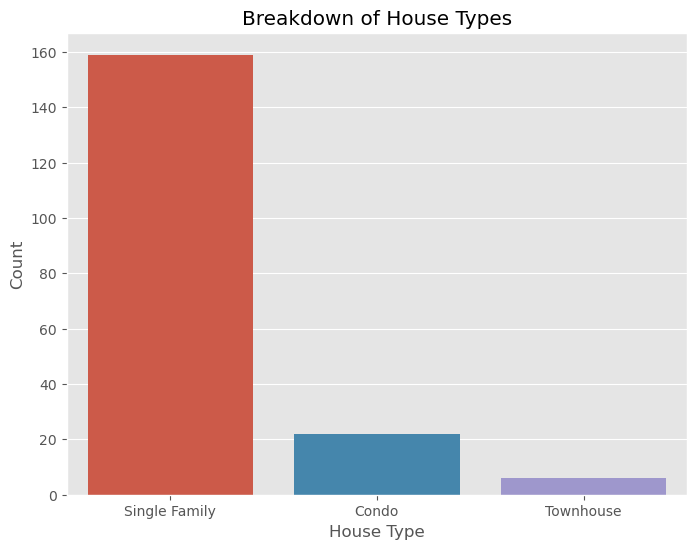

In [6]:
# Bar chart showing the breakdown of different types of houses
plt.figure(figsize=(8, 6))
sns.countplot(x='PropType', data=cleaned_df)
plt.title('Breakdown of House Types')
plt.xlabel('House Type')
plt.ylabel('Count')
plt.show()


              Acres  LstPrice  PkgSpacs  SoldPrice     Taxes    TotBed  \
Acres      1.000000  0.662973  0.112196   0.654911  0.619466  0.518396   
LstPrice   0.662973  1.000000  0.082966   0.991779  0.822115  0.485555   
PkgSpacs   0.112196  0.082966  1.000000   0.068056  0.027862  0.128400   
SoldPrice  0.654911  0.991779  0.068056   1.000000  0.816696  0.469487   
Taxes      0.619466  0.822115  0.027862   0.816696  1.000000  0.408714   
TotBed     0.518396  0.485555  0.128400   0.469487  0.408714  1.000000   
TotBth     0.379504  0.603203  0.078292   0.589491  0.620258  0.505847   
TotSqf     0.675263  0.792350  0.096671   0.782777  0.758053  0.644546   
YearBlt    0.152762  0.290351 -0.167538   0.289485  0.373900 -0.056962   

             TotBth    TotSqf   YearBlt  
Acres      0.379504  0.675263  0.152762  
LstPrice   0.603203  0.792350  0.290351  
PkgSpacs   0.078292  0.096671 -0.167538  
SoldPrice  0.589491  0.782777  0.289485  
Taxes      0.620258  0.758053  0.373900  
TotBed 

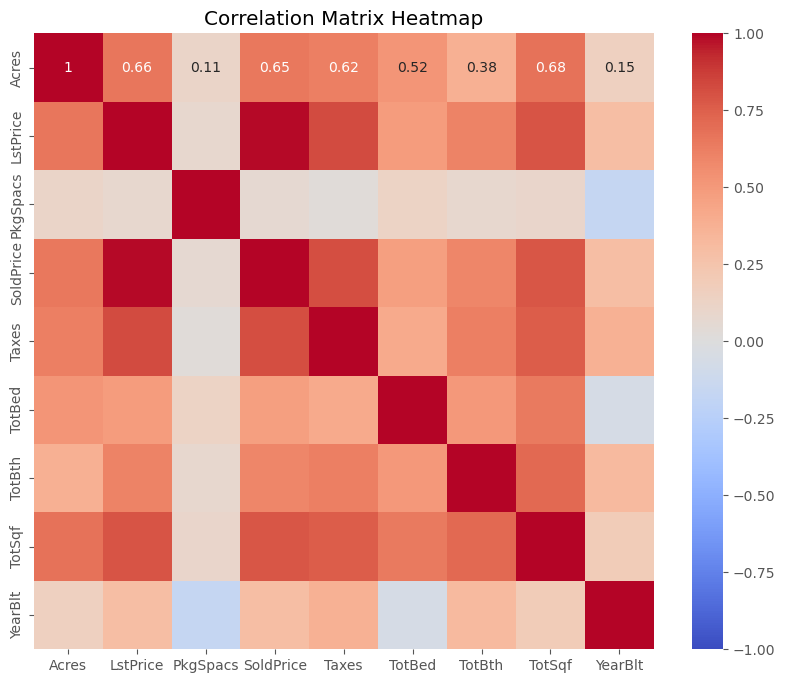

In [7]:
columns_subset = [ 'Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt' ]
correlation_matrix = cleaned_df[columns_subset].corr()
print(correlation_matrix) 

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = cleaned_df[['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()



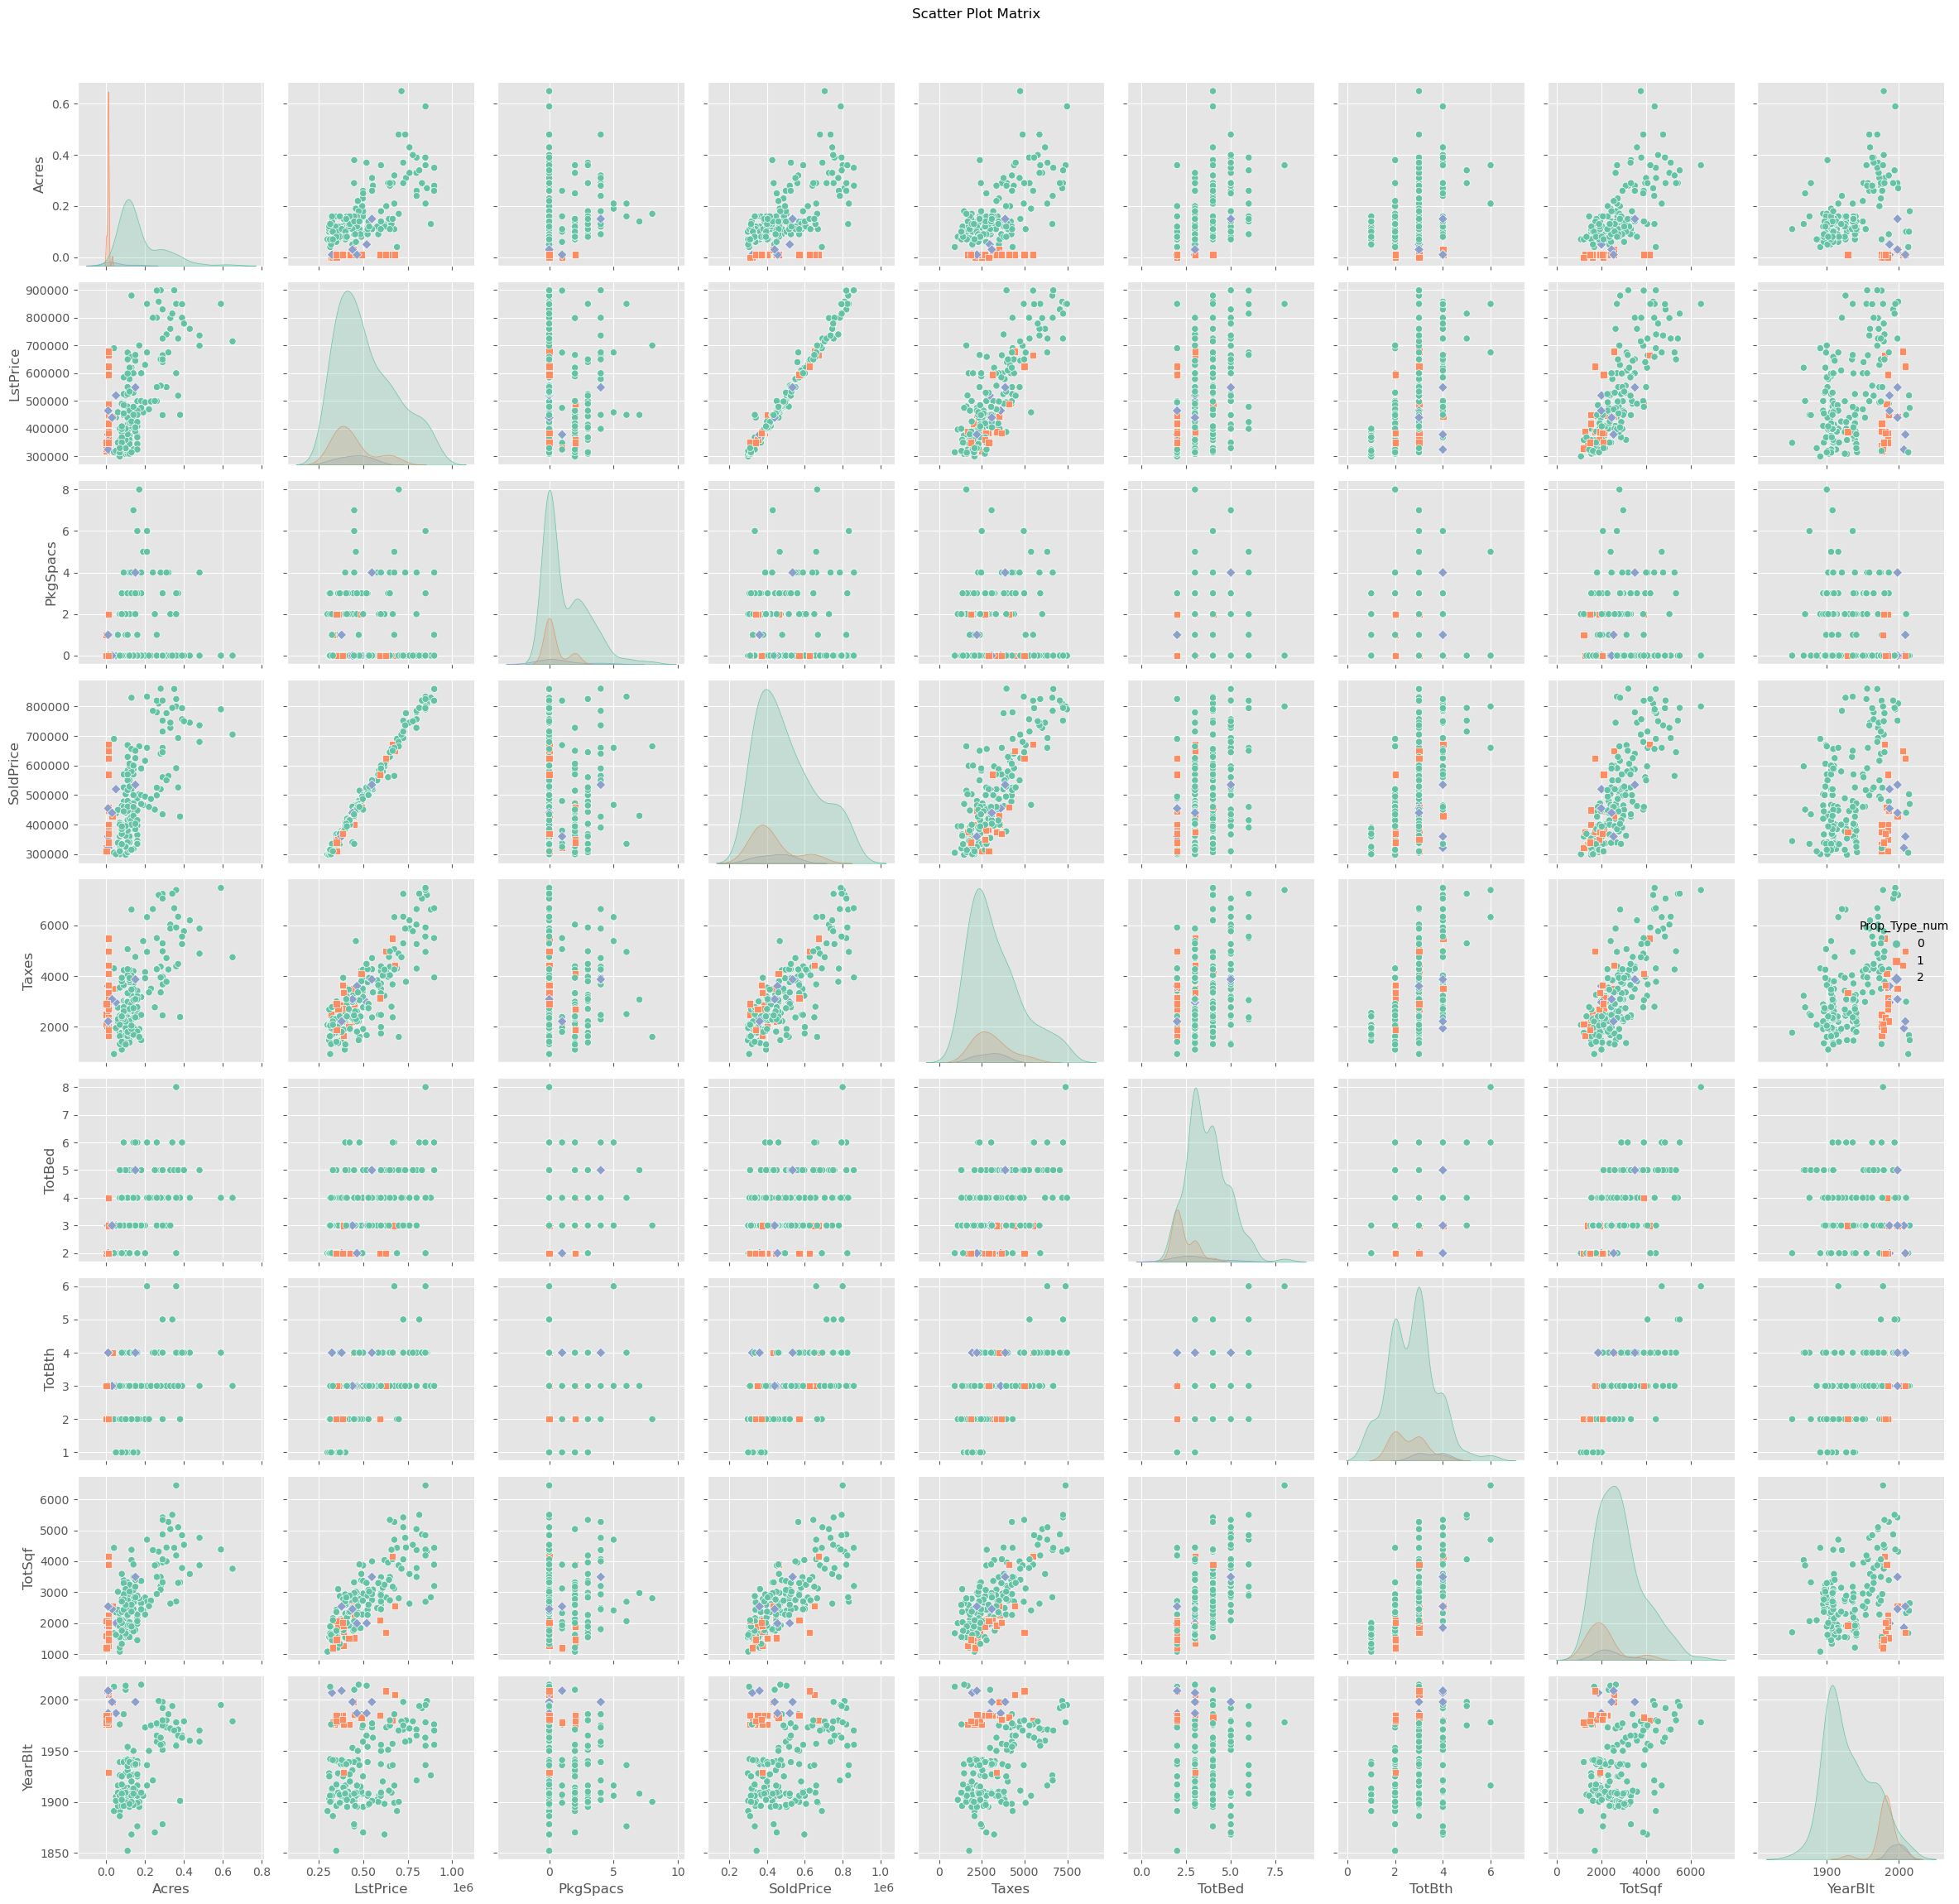

In [8]:
# Subset of columns for the scatter plot matrix
columns_subset = ['Acres', 'LstPrice', 'PkgSpacs', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'Prop_Type_num']

# Create a pair plot with color-coded dots by property type
scatter_matrix = sns.pairplot(cleaned_df[columns_subset], hue='Prop_Type_num', palette='Set2', markers=["o", "s", "D"])

# Adjust labels for better visibility
scatter_matrix.fig.suptitle('Scatter Plot Matrix', y=1.02)
plt.tight_layout()
plt.show()

By looking at the heatmap and the scatter plot, we can see where there are some correlations between the diffrent variables, the strongest correlations being between taxes and Lstprice, TotSqf and LstPrice, SoldPrice and TotSqf, TotSqf and Acres. PkgSpacs and YearBlt seem to have little correaltion with the other variables. We also see that  there are a  lot  more listings for Single Family Homes then for town houses  or condos, we can tell townhouse are newer (constructed past 1990's).

### Task 4: Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

What can you say about the relation between the location and the house price?  

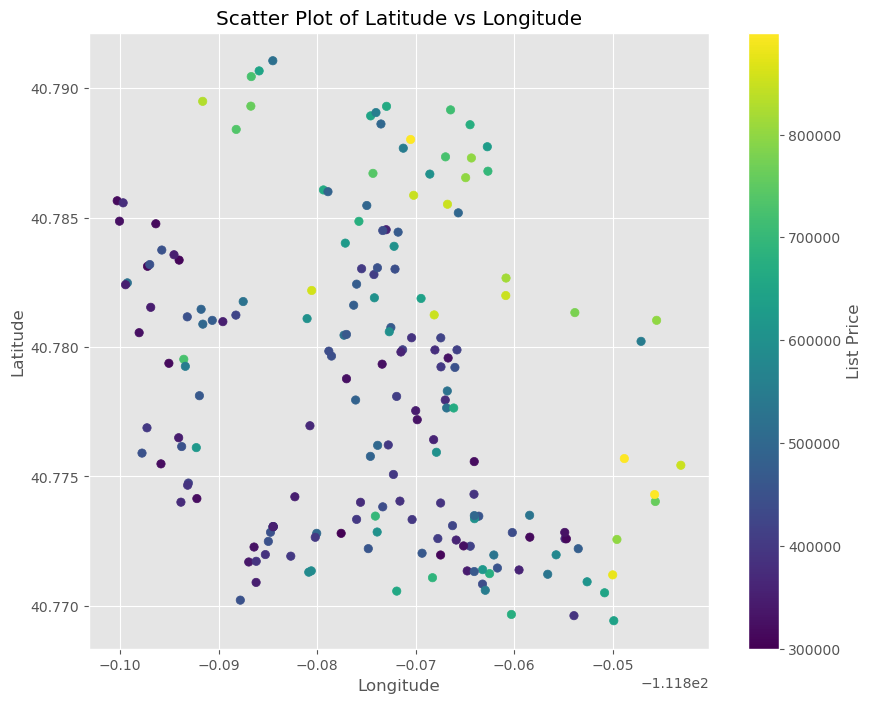

In [9]:
# Create a scatter plot of Latitude vs Longitude with color-coded points based on house price
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x=cleaned_df['Longitude'], y=cleaned_df['Latitude'], c=cleaned_df['LstPrice'])
plt.colorbar(scatter, label='List Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Latitude vs Longitude')
plt.show()

From the plot we can confirm the idea that nicer/ more expensive homes tend to be in the North East while the cheaper homes tend to be in the south west. East to West location is more of a determinate for house cost then South  to North location.


### Task 5: Simple  Linear Regression 
Use the `ols` function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (`SoldPrice ~ LstPrice`) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a scatterplot of list price vs. sold price and overlay the prediction coming from your regression model. 

In [10]:
import statsmodels.api as sm

# Add a constant term for the intercept
X = sm.add_constant(cleaned_df['LstPrice'])

# Fit the linear regression model
model = sm.OLS(cleaned_df['SoldPrice'], X).fit()

# Get the R-squared value
r_squared = model.rsquared
print(f'R-squared value: {r_squared}')

R-squared value: 0.9836254928995916


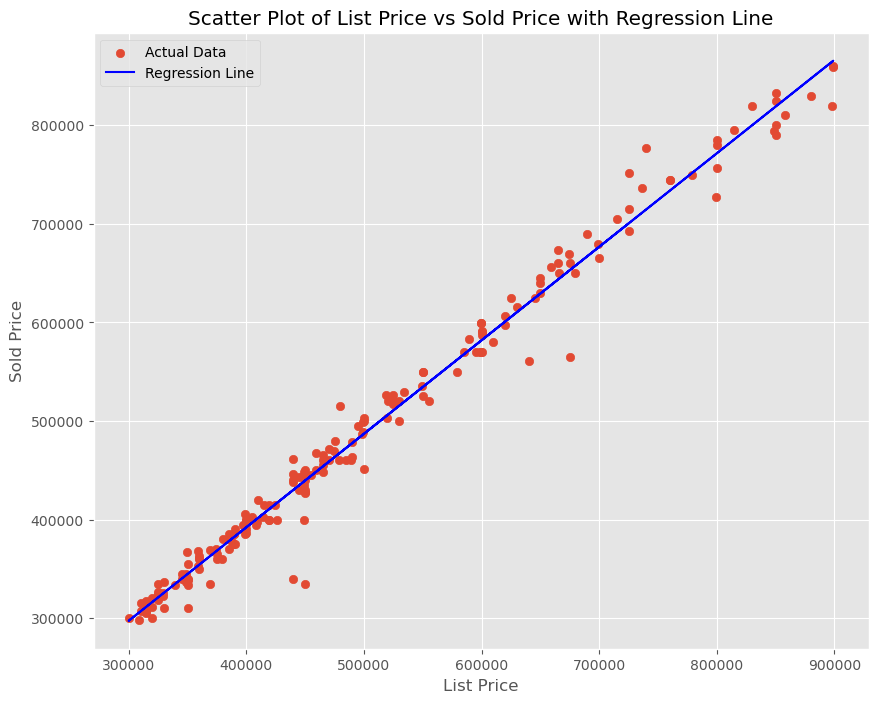

In [11]:
predictions = model.predict(X)

# Scatter plot of List Price vs Sold Price with the regression line
plt.figure(figsize=(10, 8))
plt.scatter(cleaned_df['LstPrice'], cleaned_df['SoldPrice'], label='Actual Data')
plt.plot(cleaned_df['LstPrice'], predictions, color='blue', label='Regression Line')
plt.xlabel('List Price')
plt.ylabel('Sold Price')
plt.title('Scatter Plot of List Price vs Sold Price with Regression Line')
plt.legend()
plt.show()

From this data we can intpret that typically houses will sell for a little bit less than the asking listed price, that being said the linear regression line shows us that this change in sold price and list price dosent vary as house prices go up or down. β1 represents the estimated change in the SoldPrice for a change in the LstPrice).

### Task 6: Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables.


**Question 1**: If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

Next look at the difference between list price and sold price explicitly. Calculate two new columns for your dataset. `DiffPriceAbsolute` and `DiffPriceRelative`.

* `DiffPriceAbsolute` - This is difference between sold price and list price. If it is positive, that means the house sold for more than it was listed at.
* `DiffPriceRelative` - This is the relative difference between sold price and list price. A value of 1.1 here means that the house sold for 110% of the asking price, and 0.9 means the house sold for 90% of the asking price.

Now, create two new models. One to predict `DiffPriceAbsolute`, and one to predict `DiffPriceRelative`. Use the same predictive variables as in the last model.


**Question 2**: Which of these two new models makes better predictions.

**Question 3**: Based on your answer to question two, why are these models different/the same.

To help justify your answer to question 3, train two models to predict `DiffPriceAbsolute` and `DiffPriceRelative` based on just `SoldPrice`. In addition, for each model make a scatterplots similar to Task 5 for these models.

In [12]:
y = cleaned_df['SoldPrice'].copy()

# Convert 'TotSqf' to integer, removing non-numeric characters
cleaned_df['TotSqf'] = cleaned_df['TotSqf'].replace('[^0-9]', '', regex=True).astype(int)

# Selecting predictive variables
X = cleaned_df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']].copy()

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fit the multilinear regression model
model_multilinear = sm.OLS(y, X).fit()

r_squared_multilinear = model_multilinear.rsquared
print(f"R-squared for Multilinear Model: {r_squared_multilinear}")

R-squared for Multilinear Model: 0.7659882458720343


The R Squared values for my  Multilinear model was 0.766 while the R-Squared of the Singular model was  0.983. This is likely a result of people who are listing their homes for sale have likely had it appraised and then based their price off  of that. (I would assume that the appraisal takes in to count everything I am now, plus many other factors).

In [13]:
cleaned_df['DiffPriceAbsolute'] = cleaned_df['SoldPrice'] - cleaned_df['LstPrice']
cleaned_df['DiffPriceRelative'] = cleaned_df['SoldPrice'] / cleaned_df['LstPrice']


print(cleaned_df[['DiffPriceAbsolute', 'DiffPriceRelative']].head())

   DiffPriceAbsolute  DiffPriceRelative
0              27000           1.037241
2                  0           1.000000
3              -2000           0.995506
5              -5000           0.985251
6             -30000           0.950000


In [14]:
# Model to predict DiffPriceAbsolute
y_absolute = cleaned_df['DiffPriceAbsolute']
X_absolute = cleaned_df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]
X_absolute = sm.add_constant(X_absolute)
model_absolute = sm.OLS(y_absolute, X_absolute).fit()

# Model to predict DiffPriceRelative
y_relative = cleaned_df['DiffPriceRelative']
X_relative = cleaned_df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude',  'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]
X_relative = sm.add_constant(X_relative)
model_relative = sm.OLS(y_relative, X_relative).fit()

r_squared_a = model_absolute.rsquared
print(f"R-squared for Absolute Model: {r_squared_a}")
r_squared_r = model_relative.rsquared
print(f"R-squared for Relative Model: {r_squared_r}")


R-squared for Absolute Model: 0.17051080249160377
R-squared for Relative Model: 0.07691961545501147


Based off the R squared values of the   two  different models I would assume  that  the Absolute model is better than the Relative model.

The  reason the models are diffrent (Though both are not that great) is becuase of  how they approach the selling cost of a house, the absolute keeps actual numbers, the actual dollar amount. While the relative model standardizes the costs.  This standardization appears to lose some  of the accuracy in my models.



R-squared for DiffPriceAbsolute: 0.065
R-squared for DiffPriceRelative: -0.010


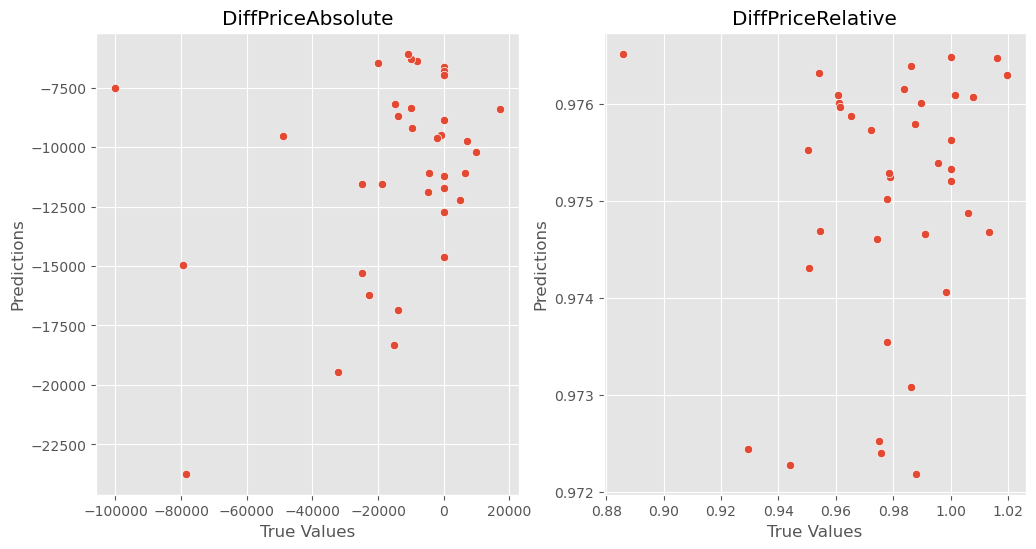

In [15]:
# Calculate DiffPriceAbsolute and DiffPriceRelative
cleaned_df['DiffPriceAbsolute'] = cleaned_df['SoldPrice'] - cleaned_df['LstPrice']
cleaned_df['DiffPriceRelative'] = cleaned_df['SoldPrice'] / cleaned_df['LstPrice']

# Split the data into training and testing sets

X_absolute = cleaned_df[['SoldPrice']]
y_absolute = cleaned_df['DiffPriceAbsolute']

X_relative = cleaned_df[['SoldPrice']]
y_relative = cleaned_df['DiffPriceRelative']


X_train_absolute, X_test_absolute, y_train_absolute, y_test_absolute = train_test_split(X_absolute, y_absolute, test_size=0.2, random_state=14)
X_train_relative, X_test_relative, y_train_relative, y_test_relative = train_test_split(X_relative, y_relative, test_size=0.2, random_state=15)


# Train Linear Regression models
model_absolute = LinearRegression()
model_absolute.fit(X_train_absolute, y_train_absolute)

model_relative = LinearRegression()
model_relative.fit(X_train_relative, y_train_relative)

# Make predictions
predictions_absolute = model_absolute.predict(X_test_absolute)
predictions_relative = model_relative.predict(X_test_relative)

# Calculate R-squared values
r2_absolute = r2_score(y_test_absolute, predictions_absolute)
r2_relative = r2_score(y_test_relative, predictions_relative)

print(f'R-squared for DiffPriceAbsolute: {r2_absolute:.3f}')
print(f'R-squared for DiffPriceRelative: {r2_relative:.3f}')

# DiffPriceAbsolute Scatterplot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_absolute, y=predictions_absolute)
plt.title(f'DiffPriceAbsolute')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# DiffPriceRelative Scatterplot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_relative, y=predictions_relative)
plt.title(f'DiffPriceRelative')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()



The two given  scatter plots and R squared values support my claims given in question 2, That the absloute values model is more reliable for predicting price.

### Task 7: Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

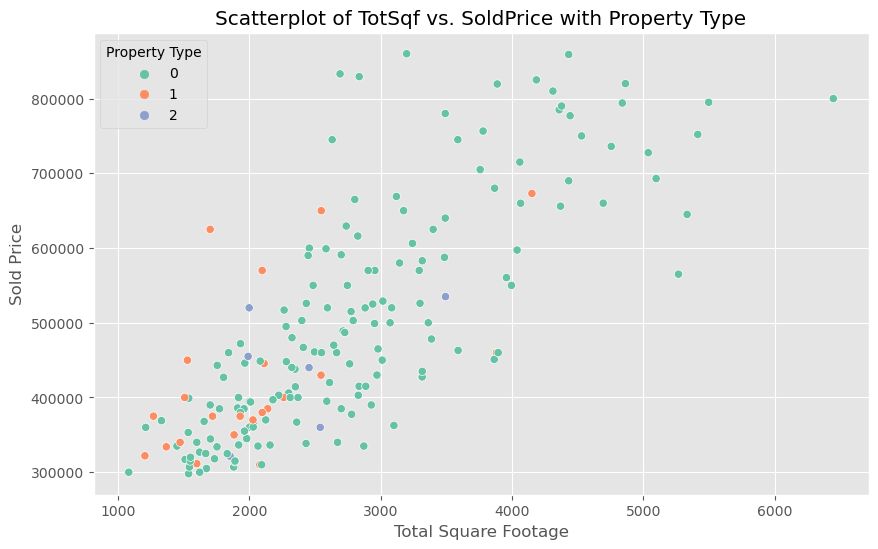

In [16]:
# Create a scatterplot with different colors for each property type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='TotSqf', y='SoldPrice', hue='Prop_Type_num', palette='Set2')

# Add labels and title
plt.xlabel('Total Square Footage')
plt.ylabel('Sold Price')
plt.title('Scatterplot of TotSqf vs. SoldPrice with Property Type')

# Show the legend
plt.legend(title='Property Type')

# Show the plot
plt.show()

My explination for this occuring is likely a result of townhouses and Condos being newer built and therefor more valuable, until they are compared to homes that actually come with larger properties or are larger homes in gerneral. (As condos  and townhomes tend to be smaller). This plot shows that size of a  home out ranks the newness or the  type of home.